# Import python packages

In [1]:
from collections import defaultdict
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import random

np.random.seed(7)

# Define parameters and load bgp_routes and ToR datasets

In [2]:
ToR_MODEL_NAME = "CAIDA_s1_ToR_Classification_NDToR_CP-Core"

TEST_SIZE = 0.2
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}
class_names = ['P2P', 'C2P', 'P2C']
DATA_PATH = '../../Data/'
MODELS_PATH = '../../Models/'
RESULTS_PATH = '../../Results/'


bgp_routes = np.load(DATA_PATH + "bgp_routes_dataset.npy")
bgp_routes_labels = np.load(DATA_PATH + "bgp_routes_labels.npy")
print(bgp_routes.shape, bgp_routes_labels.shape)

DATA = "caida_s1_tor"
tor_dataset = np.load(DATA_PATH + DATA + "_dataset.npy")
tor_labels = np.load(DATA_PATH + DATA + "_labels.npy")

print(tor_dataset.shape, tor_labels.shape)

(3669655,) (3669655,)
(580762, 2) (580762,)


# Generate training and test sets
## Shauffle dataset

In [3]:
from sklearn.utils import shuffle
dataset, labels = shuffle(tor_dataset, tor_labels, random_state=7)

## Generate a balanced dataset

In [ ]:
# def generate_balanced_dataset(dataset, labels, labels_set):
#     sets_dict = dict()
#     for label in labels_set:
#         sets_dict[label] = np.asarray([np.asarray(dataset[i]) for i in range(len(dataset)) if labels[i] == label])
    
#     min_set_len = min([len(label_set) for label_set in sets_dict.values()])
    
#     for label, label_set in sets_dict.items():
#         sets_dict[label] = label_set[np.random.choice(label_set.shape[0], min_set_len, replace=False)]
    
#     dataset = np.concatenate((sets_dict.values()))
#     labels = []
#     for label, label_set in sets_dict.items():
#         labels += [label]*len(label_set)
#         print label, len(label_set)
#     labels = np.asarray(labels)
#     return shuffle(dataset, labels, random_state=7)

# dataset, labels = generate_balanced_dataset(dataset, labels, (0,1,3))
# print dataset.shape, labels.shape

## Train Test Split

In [4]:
x_training, x_test, y_training, y_test = train_test_split(dataset, labels, test_size=TEST_SIZE)

del dataset, labels

In [5]:
print(x_training.shape, y_training.shape)
print(x_test.shape, y_test.shape)

print(1.0*len(x_training)/(len(x_test)+len(x_training)))

from collections import Counter
training_c = Counter(y_training)
test_c = Counter(y_test)
print(training_c, test_c)

(464609, 2) (464609,)
(116153, 2) (116153,)
0.7999989668745545
Counter({0: 275382, 1: 94716, 2: 94511}) Counter({0: 68570, 2: 23894, 1: 23689})


In [6]:
for k,v in training_c.items():
    print(k, 100.0*v/len(x_training))
print
for k,v in test_c.items():
    print(k, 100.0*v/len(x_test))

1 20.386174180870366
0 59.27177476114324
2 20.342051057986392
0 59.03420488493625
2 20.571143233493753
1 20.39465188157


# Run ND-ToR Algo

## Load k_shell

In [18]:
with open(MODELS_PATH + 's1_k_shell.pickle', 'rb') as handle:
    k_shell = pickle.load(handle)
print(len(k_shell))

FileNotFoundError: [Errno 2] No such file or directory: '../../Models/k_shell.pickle'

## Load CAIDA results and create CP-Core with NetworkX

In [10]:
caida_p2p = [tor for i, tor in enumerate(tor_dataset) if tor_labels[i] == 0]

TIER1 = ["174", "209", "286", "701", "1239", "1299", "2828", "2914", "3257", "3320", "3356",
         "3491", "5511", "6453", "6461", "6762", "6830", "7018", "12956"]
# with open(caida_path, "r") as f:
#     for line in f:
#         as0, as1, label = [int(part) for part in line.split()[0].split('|')]
#         if label == 0 and as0 in ASN_index_map and as1 in ASN_index_map:
#             caida_p2p.append((ASN_index_map[as0], ASN_index_map[as1]))
caida_p2p = [tor for i, tor in enumerate(tor_dataset) if tor_labels[i] == 0]
print(len(caida_p2p))

343952


In [11]:
import networkx as nx

verteces = set()
for pair in caida_p2p:
    verteces.add(pair[0])
    verteces.add(pair[1])
print(len(verteces))

vertex2ind = dict()
ind2vertex = dict()
for i, vertex in enumerate(verteces):
    vertex2ind[vertex] = i
    ind2vertex[i] = vertex

print(len(vertex2ind), len(ind2vertex))

g = nx.DiGraph()
g.add_edges_from([(vertex2ind[pair[0]], vertex2ind[pair[1]]) for pair in caida_p2p])
g.add_edges_from([(vertex2ind[pair[1]], vertex2ind[pair[0]]) for pair in caida_p2p])

SCCs = [c for c in sorted(nx.strongly_connected_components(g),key=len, reverse=True)]

12254
12254 12254


In [12]:
print(len(SCCs))
for i, scc in enumerate(SCCs):
    for as_tier1 in TIER1:
        if vertex2ind[as_tier1] not in scc:
            break
        print(i)
print(len(SCCs[0]))
scc = SCCs[0]
scc = set([ind2vertex[ind] for ind in scc])
print(len(scc))

114
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
11889
11889


In [15]:
cp_core = set()
for pair in caida_p2p:
    if pair[0] in scc and pair[1] in scc:
        cp_core.add(tuple(pair))
        cp_core.add(tuple((pair[1], pair[0])))
print(len(cp_core))
print("numbr of edges " + str(len(cp_core)/2))

343446
numbr of edges 171723.0


## Load CAIDA results and create CP-Core

In [8]:
caida_path = 'CAIDA_20181001.as-rel_cleaned.txt'
caida_p2p = list()

TIER1 = [7018, 209, 3356, 3549, 4323, 3320, 3257, 286, 6830, 2914, 5511, 3491, 1239, 6453, 6762, 12956, 701, 702, 703, 2828, 6461]
TIER1 = [ASN_index_map[asn] for asn in TIER1]

with open(caida_path, "r") as f:
    for line in f:
        as0, as1, label = [int(part) for part in line.split()[0].split('|')]
        if label == 0 and as0 in ASN_index_map and as1 in ASN_index_map:
            caida_p2p.append((ASN_index_map[as0], ASN_index_map[as1]))
print(len(caida_p2p))

192088


In [13]:
#This class represents a directed graph using adjacency list representation 
class Graph: 
   
    def __init__(self,vertices): 
        self.V = vertices #No. of vertices 
        self.graph = defaultdict(list) # default dictionary to store graph
        self.scc_list = []
   
    # function to add an edge to graph 
    def addEdge(self,u,v): 
        self.graph[u].append(v) 
   
    # A function used by DFS 
    def DFSUtil(self,v,visited): 
        # Mark the current node as visited and print it 
        visited[v]= True
#         print v,
        self.scc_list[-1].append(v)
        #Recur for all the vertices adjacent to this vertex 
        for i in self.graph[v]: 
            if visited[i]==False: 
                self.DFSUtil(i,visited) 
  
  
    def fillOrder(self,v,visited, stack): 
        # Mark the current node as visited  
        visited[v]= True
        #Recur for all the vertices adjacent to this vertex 
        for i in self.graph[v]: 
            if visited[i]==False: 
                self.fillOrder(i, visited, stack) 
        stack = stack.append(v) 
      
  
    # Function that returns reverse (or transpose) of this graph 
    def getTranspose(self): 
        g = Graph(self.V) 
  
        # Recur for all the vertices adjacent to this vertex 
        for i in self.graph: 
            for j in self.graph[i]: 
                g.addEdge(j,i) 
        return g 
  
   
   
    # The main function that finds and prints all strongly 
    # connected components 
    def printSCCs(self): 
          
        stack = [] 
        # Mark all the vertices as not visited (For first DFS) 
        visited =[False]*(self.V) 
        # Fill vertices in stack according to their finishing 
        # times 
        for i in range(self.V): 
            if visited[i]==False: 
                self.fillOrder(i, visited, stack) 
  
        # Create a reversed graph 
        gr = self.getTranspose() 
          
        # Mark all the vertices as not visited (For second DFS) 
        visited =[False]*(self.V) 
  
        # Now process all vertices in order defined by Stack 
        while stack: 
            i = stack.pop() 
            if visited[i]==False:
                gr.scc_list.append([])
                gr.DFSUtil(i, visited) 
#                 print""
        
        scc = gr.scc_list
        return scc



In [30]:
verteces = set()
for pair in caida_p2p:
    verteces.add(pair[0])
    verteces.add(pair[1])
print(len(verteces))

vertex2ind = dict()
ind2vertex = dict()
for i, vertex in enumerate(verteces):
    vertex2ind[vertex] = i
    ind2vertex[i] = vertex

print(len(vertex2ind), len(ind2vertex))

g = Graph(len(verteces))
for pair in caida_p2p:
    g.addEdge(vertex2ind[pair[0]], vertex2ind[pair[1]])
    g.addEdge(vertex2ind[pair[1]], vertex2ind[pair[0]])

SCCs = g.printSCCs()

13083
(13083, 13083)


In [32]:
print(len(SCCs))
for i, scc in enumerate(SCCs):
    for as_tier1 in TIER1:
        if vertex2ind[as_tier1] not in scc:
            break
        print(i)
print(len(SCCs[134]))
scc = SCCs[134]
scc = set([ind2vertex[ind] for ind in scc])
print(len(scc))

135
134
134
134
134
134
134
134
134
134
134
134
134
134
134
134
134
134
134
134
134
134
12618
12618


In [34]:
cp_core = set()
for pair in caida_p2p:
    if pair[0] in scc and pair[1] in scc:
        cp_core.add(pair)
        cp_core.add((pair[1], pair[0]))
print(len(cp_core))
print("numbr of edges " + str(len(cp_core)/2))

383512
numbr of edges 191756


## Create k_max-core

In [25]:
k_max = max(ndtor_cp.k_shell.values())
k_max_core = [vertex for vertex, k in ndtor_cp.k_shell.items() if k == k_max]
print(len(k_max_core))

21


In [26]:
k_max_edges = set()
for i in range(len(k_max_core)):
    for j in range(i):
        if (k_max_core[i], k_max_core[j]) in x_training or (k_max_core[i], k_max_core[j]) in x_test:
            k_max_edges.add((k_max_core[i], k_max_core[j]))
        if (k_max_core[j], k_max_core[i]) in x_training or (k_max_core[j], k_max_core[i]) in x_test:
            k_max_edges.add((k_max_core[j], k_max_core[i]))
            
print(len(k_max_edges))

420


## Create x_training_core

In [34]:
x_training_edges = set()
x_training_vertecs = set()
for pair in x_training:
    x_training_edges.add((pair[0], pair[1]))
    x_training_vertecs.add(pair[0])
    x_training_vertecs.add(pair[1])
print(len(x_training_edges), len(x_training_vertecs))

(90388, 47794)


## Run NDTOR_CP

In [26]:
class NDTOR_CP:
    def __init__(self, core_verteces, core_edges, routing_tables, core_labels=None, is_core=True, threshold=0.85, k_shell=None):
        if is_core:
            self.tor_dict = self.__intialize_tor_dict_with_core(core_edges)
            print('Finished __intialize_tor_dict_with_core')
            self.pahse2_routes = self.__split_path_through_core(routing_tables, core_verteces)
        else:
            self.tor_dict = self.__intialize_tor_dict_with_training_set(core_edges, core_labels)
            print('Finished __intialize_tor_dict_with_training_set')
            self.pahse2_routes = routing_tables
        print('Finished __split_path_through_core with ' + str(len(self.pahse2_routes)) + ' remaining for phase 2')
        self.unclassified_pairs = self.__pahse2(threshold)
        print('Finished __pahse2 with ' + str(len(self.unclassified_pairs)) + " unclassified pairs")
        self.__pahse3()
        print('Finished __pahse3 with ' + str(len(self.unclassified_pairs)) + " unclassified pairs")
        
        if len(self.unclassified_pairs) > 0:
            if k_shell is None:
                self.k_shell = self.__compute_k_shells(routing_tables)
            else:
                self.k_shell = k_shell
            print("Finished __compute_k_shells")
            self.__compare_k_shells()
            print("Finished __compare_k_shells")
    
    
    def __intialize_tor_dict_with_training_set(self, core_edges, core_labels):
        tor_dict = dict()
        for i, edge in enumerate(core_edges):
            tor_dict[edge] = core_labels[i]
        return tor_dict
    

    def __intialize_tor_dict_with_core(self, core_edges):
        tor_dict = dict()
        for edge in core_edges:
            tor_dict[edge] = 0 # 0 - p2p
        return tor_dict
        
    def __split_path_through_core(self, routes, core_verteces):
        pahse2_routes = list()
        for path in routes:
            core_inds = list()
            for j, vertex in enumerate(path):
                if vertex in core_verteces:
                    core_inds.append(j)
            if len(core_inds) == 0:
                pahse2_routes.append(path)
            else:
                for i in range(core_inds[0]):
                    if (path[i], path[i+1]) not in self.tor_dict:
                        self.tor_dict[(path[i], path[i+1])] = 1 # 1 - c2p
                        self.tor_dict[(path[i+1], path[i])] = 3
                for i in range(core_inds[0], core_inds[-1]):
                    if (path[i], path[i+1]) not in self.tor_dict:
                        self.tor_dict[(path[i], path[i+1])] = 0 # 0 - p2p
                        self.tor_dict[(path[i+1], path[i])] = 0 
                for i in range(core_inds[-1], len(path)-1):
                    if (path[i], path[i+1]) not in self.tor_dict:
                        self.tor_dict[(path[i], path[i+1])] = 3 # 0 - p2c
                        self.tor_dict[(path[i+1], path[i])] = 1
        return pahse2_routes
    
    
    def __pahse2(self, threshold):
        votings_p2c = defaultdict(lambda:0)
        votings_c2p = defaultdict(lambda:0)
        voting_pairs = set()
        
        for path in self.pahse2_routes:
            pairs = list(zip(path[:-1], path[1:]))
            pairs_tor = []
            for i, pair in enumerate(pairs):
                if pair in self.tor_dict:
                    pairs_tor.append(self.tor_dict[pair])
                else:
                    pairs_tor.append(-1)
                    voting_pairs.add(pair)
            for i in range(len(pairs)):
                if pairs_tor[i] == -1:
                    if i > 1 and pairs_tor[i-1] == 3: #p2c
                        pairs_tor[i] = 3
                        votings_p2c[pairs[i]] += 1
                    if i + 1 < len(pairs) and pairs_tor[i+1] == 1: #c2p
                        pairs_tor[i] = 1
                        votings_c2p[pairs[i]] += 1
        
        unclassified_pairs = set()
        for pair in voting_pairs:
            if (votings_p2c[pair] + votings_c2p[pair]) > 0:
                rank = (votings_p2c[pair]*1.0)/(votings_p2c[pair] + votings_c2p[pair])
                if rank >= threshold:
                    self.tor_dict[pair] = 3
                elif rank <= (1 - threshold):
                    self.tor_dict[pair] = 1
                else:
                    unclassified_pairs.add(pair)
            else:
                unclassified_pairs.add(pair)
        return unclassified_pairs
    
    def __pahse3(self):
        for path in self.pahse2_routes:
            pairs = list(zip(path[:-1], path[1:]))
            if len(pairs) > 2: 
                for i in range(1,len(pairs)-1):
                    if pairs[i] not in self.tor_dict and pairs[i-1] in self.tor_dict and pairs[i+1] in self.tor_dict:
                        if self.tor_dict[pairs[i-1]] == 1 and self.tor_dict[pairs[i+1]] == 3:
                            self.tor_dict[pairs[i]] = 0
                            self.unclassified_pairs.remove(pairs[i])
                        elif self.tor_dict[pairs[i-1]] == 3 and self.tor_dict[pairs[i+1]] == 1:
                            self.tor_dict[pairs[i]] = 0
                            self.unclassified_pairs.remove(pairs[i])
    
    
    def __get_k_shell(self, k, edges, k_shell):
        neighbors = defaultdict(set)
        k_shell_verteces = set()
        for edge in edges:
            neighbors[edge[0]].add(edge)
            neighbors[edge[1]].add(edge)
        for asn, asn_edges in neighbors.items():
            if len(asn_edges) <= k:
                k_shell[asn] = k
                k_shell_verteces.add(asn)
                
        return neighbors, k_shell_verteces
    
    
    def __get_graph_for_routes(self, P):
        edges = []
        for route in P:
            for edge in zip(route[:-1], route[1:]):
                edges.append(edge)
        return set(edges)
                
    
    def __remove_k_shell_edges(self, edges, k_shell_verteces, neighbors):
        for vertex in k_shell_verteces:
            edges = edges - neighbors[vertex]
        return edges
                
                
    def __compute_k_shells(self, routes):
        k_shell = dict()
        k = 1
        edges = self.__get_graph_for_routes(routes)
        
        while len(edges) > 0:
            print("K: " + str(k) + " Start Iteration on " + str(len(edges)) + " edges")
            neighbors, k_shell_verteces = self.__get_k_shell(k, edges, k_shell)
            k += 1
            edges = self.__remove_k_shell_edges(edges, k_shell_verteces, neighbors)
            print("Number of remaining edges: " + str(len(edges)))
            print()
            
        return k_shell
        
        
    def __compare_k_shells(self):
        for pair in self.unclassified_pairs:
            try:
                as0_k = self.k_shell[pair[0]]
            except:
                as0_k = 0
            try:
                as1_k = self.k_shell[pair[1]]
            except:
                as0_k = 0
            if as0_k == as1_k:
                self.tor_dict[pair] = 0 # p2p
            elif as0_k > as1_k:
                self.tor_dict[pair] = 3 # p2c
            else:
                self.tor_dict[pair] = 1 # c2p
    
                
    def tor_dict2dataset(self):
        dataset = []
        labels = []
        for pair, label in self.tor_dict.items():
            dataset.append(np.asarray(pair))
            labels.append(label)
        print("Finished __tor_dict2dataset")
        return np.asarray(dataset), np.asarray(labels)


    def generate_labels_for_set(self, pairs):
        labels = []
        for pair in pairs:
            if (pair[0], pair[1]) in self.tor_dict:
                labels.append(self.tor_dict[(pair[0], pair[1])])
            elif (pair[1], pair[0]) in self.tor_dict:
                if self.tor_dict[(pair[1], pair[0])] == 0 or self.tor_dict[(pair[1], pair[0])] == 2:
                    labels.append(self.tor_dict[(pair[1], pair[0])])
                else:
                    labels.append((self.tor_dict[(pair[1], pair[0])] + 2)%4)
            else:
                labels.append(-1)
        return np.asarray(labels)


In [27]:
ndtor_cp = NDTOR_CP(scc, cp_core, bgp_routes,k_shell=None)   # CP - Core

Finished __intialize_tor_dict_with_core
Finished __split_path_through_core with 276 remaining for phase 2
Finished __pahse2 with 142 unclassified pairs
Finished __pahse3 with 142 unclassified pairs
K: 1 Start Iteration on 147667 edges
Number of remaining edges: 123786

K: 2 Start Iteration on 123786 edges
Number of remaining edges: 80747

K: 3 Start Iteration on 80747 edges
Number of remaining edges: 59956

K: 4 Start Iteration on 59956 edges
Number of remaining edges: 47881

K: 5 Start Iteration on 47881 edges
Number of remaining edges: 39960

K: 6 Start Iteration on 39960 edges
Number of remaining edges: 34330

K: 7 Start Iteration on 34330 edges
Number of remaining edges: 30048

K: 8 Start Iteration on 30048 edges
Number of remaining edges: 26555

K: 9 Start Iteration on 26555 edges
Number of remaining edges: 23538

K: 10 Start Iteration on 23538 edges
Number of remaining edges: 20722

K: 11 Start Iteration on 20722 edges
Number of remaining edges: 18171

K: 12 Start Iteration on 18

In [27]:
ndtor_k_max_core = NDTOR_CP(k_max_core, k_max_edges, bgp_routes, k_shell=k_shell)   # k_max_core - Core

Finished __intialize_tor_dict_with_core
Finished __split_path_through_core with 372339 remaining for phase 2
Finished __pahse2 with 17235 unclassified pairs
Finished __pahse3 with 14145 unclassified pairs
Finished __compute_k_shells
Finished __compare_k_shells


In [41]:
### Reverse to original labels
core_labels = list()
for label in y_training:
    if label == 2:
        core_labels.append(3)
    else:
        core_labels.append(label)

ndtor_x_training_core = NDTOR_CP(x_training_vertecs, x_training_edges, bgp_routes, core_labels=core_labels, is_core=False, k_shell=k_shell)


Finished __intialize_tor_dict_with_training_set
Finished __split_path_through_core with 3669655 remaining for phase 2
Finished __pahse2 with 19960 unclassified pairs
Finished __pahse3 with 17062 unclassified pairs
Finished __compute_k_shells
Finished __compare_k_shells


In [42]:
ToR_MODEL_NAME = "Cleaned_Orig_3_ToR_Classification_NDToR_x_training_core"

with open(MODELS_PATH + ToR_MODEL_NAME + '_tor_dict.pickle', 'wb') as handle:
    pickle.dump(ndtor_k_max_core.tor_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(MODELS_PATH + 'k_shell.pickle', 'wb') as handle:
#     pickle.dump(ndtor_cp.k_shell, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
k_max = max(ndtor_cp.k_shell.values())
k_max_core = [vertex for vertex, k in ndtor_cp.k_shell.items() if k == k_max]
print(len(k_max_core))

21


In [49]:
index_ASN_map = {index: ASN for ASN, index in ASN_index_map.items()}

for ind in k_max_core:
    print(index_ASN_map[ind],)

(3356,)
(6939,)
(1299,)
(174,)
(3257,)
(2914,)
(6453,)
(209,)
(1239,)
(6762,)
(9002,)
(701,)
(6461,)
(4637,)
(3491,)
(286,)
(37100,)
(2497,)
(3303,)
(2516,)
(1273,)


## Save kshell

In [ ]:
with open(MODELS_PATH + ToR_MODEL_NAME + '_tor_dict.pickle', 'wb') as handle:
    pickle.dump(ndtor_cp.tor_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(MODELS_PATH + ToR_MODEL_NAME + 's1_k_shell.pickle', 'wb') as handle:
    pickle.dump(ndtor_cp.k_shell, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(MODELS_PATH + 's1_k_shell.pickle', 'rb') as handle:
    k_shell = pickle.load(handle)
print(len(k_shell))

# Final evaluation of the model
## Evaluate accuracy over the test set

In [7]:
with open(MODELS_PATH + ToR_MODEL_NAME + '_tor_dict.pickle', 'rb') as handle:
    cp_core_tor_dict = pickle.load(handle)

In [35]:
y_test_prediction = ndtor_cp.generate_labels_for_set(x_test)

In [36]:
print(set(y_test_prediction))

{0, 1, 3, -1}


In [37]:
print(len(y_test_prediction))
y_test_prediction_new = []
for i in range(len(y_test_prediction)):
    if y_test_prediction[i] %2 == 0:
        y_test_prediction_new.append(0)
    elif y_test_prediction[i] == 3:
        y_test_prediction_new.append(2)
    elif y_test_prediction[i] == 1:
        y_test_prediction_new.append(1)
    else:
        y_test_prediction_new.append(-1)

y_test_prediction_new = np.asarray(y_test_prediction_new)
print(len(y_test_prediction_new))
y_test_prediction = y_test_prediction_new

116153
116153


In [38]:
print(set(y_test_prediction))

{0, 1, 2, -1}


In [40]:
y_test = [y_test[i] for i, label in enumerate(y_test_prediction) if label!=-1]
y_test_prediction = [label for i, label in enumerate(y_test_prediction) if label!=-1]
print(set(y_test_prediction))
print(len(y_test), len(y_test_prediction))

{0, 1, 2}
109774 109774


In [41]:
from sklearn.metrics import accuracy_score
test_scores = accuracy_score(y_test, y_test_prediction)
print("Accuracy: %.2f%%" % (test_scores*100))

Accuracy: 89.04%


In [ ]:
# x_test_cleaned = np.asarray([np.asarray(x_test[i]) for i in range(len(x_test)) if y_test_prediction[i] != -1])
# y_test_cleaned = np.asarray([y_test[i] for i in range(len(y_test)) if y_test_prediction[i] != -1])
# y_test_prediction_cleaned = np.asarray([y_test_prediction[i] for i in range(len(y_test_prediction)) if y_test_prediction[i] != -1])

In [ ]:
# print(len(x_test_cleaned), len(y_test_cleaned), len(y_test_prediction_cleaned))

In [ ]:
# from sklearn.metrics import accuracy_score
# test_scores = accuracy_score(y_test_cleaned, y_test_prediction_cleaned)
# print("Accuracy: %.2f%%" % (test_scores*100))

## Test if by learning (asn1, asn2) -> p2c then (asn2, asn1) -> c2p and vice versa

In [ ]:
p2c = TOR_ORIG_LABELS_DICT['P2C']
c2p = TOR_ORIG_LABELS_DICT['C2P']

p2c_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2c])
p2c_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2c_training])
p2c_training_labels = [p2c]*len(p2c_training)
p2c_training_oposite_labels = [c2p]*len(p2c_training_oposite)
print(p2c_training.shape, p2c_training_oposite.shape)

In [ ]:
p2c_training_labels_prediction = generate_labels_for_set(caida_tor_dict, p2c_training)
p2c_training_scores = accuracy_score(p2c_training_labels, p2c_training_labels_prediction)
print("Accuracy: %.2f%%" % (p2c_training_scores*100))

p2c_training_oposite_labels_prediction = generate_labels_for_set(caida_tor_dict, p2c_training_oposite)
p2c_training_oposite_scores = accuracy_score(p2c_training_oposite_labels, p2c_training_oposite_labels_prediction)
print("Accuracy: %.2f%%" % (p2c_training_oposite_scores*100))

## Plot and save a confusion matrix for results over the test set

### Define a function

In [32]:
%matplotlib inline

import matplotlib
import pylab as pl
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(fname, bbox_inches='tight')

Confusion matrix, without normalization
Normalized confusion matrix


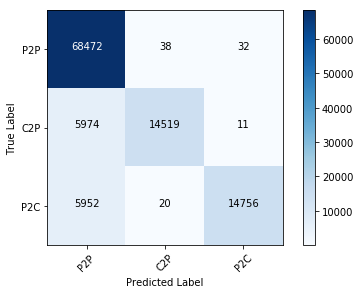

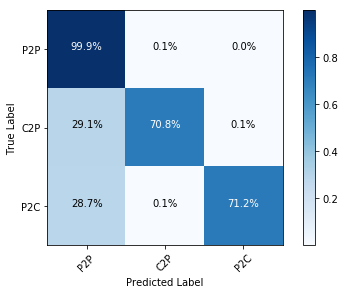

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=RESULTS_PATH + ToR_MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Msatrix',
                      fname=RESULTS_PATH +ToR_MODEL_NAME + "_" + 'Normalized_confusion_matrix')

plt.show()

# Export the model to a file

In [ ]:
model_json = pairs_model.to_json()
with open(MODELS_PATH + ToR_MODEL_NAME + '.json', "w") as json_file:
    json_file.write(model_json)
pairs_model.save_weights(MODELS_PATH + ToR_MODEL_NAME + '.h5')
print("Save Model")

# Export results to a csv file (with original ASNs)
## Define functions

In [ ]:
def index2ASN(dataset_indexed, ASN_index_map):
    dataset = []
    index_ASN_map = {index: ASN for ASN, index in ASN_index_map.items()}
    for row_indexed in dataset_indexed:
        row = []
        for index in row_indexed:
            if index != 0:
                row += [index_ASN_map[index]]
        dataset.append(row)
    
    return dataset

def index2ASN_labeled(dataset_indexed, labels_indexed, ASN_index_map):
    dataset = []
    index_ASN_map = {index: ASN for ASN, index in ASN_index_map.items()}
    labels_colors_map = {0:'GREEN', 1:'RED'}
    
    for i, row_indexed in enumerate(dataset_indexed):
        row = []
        for index in row_indexed:
            if index != 0:
                row += [index_ASN_map[index]]
        row += [labels_colors_map[labels_indexed[i]]]
        dataset.append(row)
    
    return dataset

import csv
def export_csv(dataset, csv_name):
    with open(csv_name + '.csv', 'wb') as csv_file:
        csv_writer = csv.writer(csv_file)
        for row in dataset:
            csv_writer.writerow(row)

## Load a relevant dataset {all, misclassified, decided, undecided} and get model predictions

In [ ]:
### misclassified from the entire dataset ###

dataset = np.load(DATA_PATH + "bgp_routes_indexed_dataset.npy")
labels = np.load(DATA_PATH + "bgp_routes_labels.npy")

# remove UNDECIDED
dataset = np.asarray([np.asarray(dataset[i]) for i in range(len(dataset)) if labels[i] != 2])
labels = np.asarray([labels[i] for i in range(len(labels)) if labels[i] != 2])

# pad sequences
dataset = sequence.pad_sequences(dataset, maxlen=max_len)
# Get Model Predictions
predictions = model.predict_classes(dataset, verbose=1)

In [ ]:
# Create misclassified dataset
x_misclassified = np.asarray([route for i,route in enumerate(dataset) if labels[i] != predictions[i]])
y_misclassified_prediction = np.asarray([label for i,label in enumerate(predictions) if labels[i] != predictions[i]])
print len(x_misclassified), len(y_misclassified_prediction)

## Export Results

In [ ]:
dataset_misclassified = index2ASN_labeled(x_misclassified, y_misclassified_prediction, ASN_index_map)
export_csv(dataset_misclassified, RESULTS_PATH + MODEL_NAME + "_misclassified")